# Platoon Finding

This document aims to demonstrate the "platoon" phenomenon in a portion of the WIM data. Using years 2014-2016 in the Cereni, Denges and Gotthard stations. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import multiprocess as mp

sns.set_style('darkgrid')
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=13)
sns.set(rc={'figure.figsize':(11.7,8.27)})


Bad key "text.kerning_factor" on line 4 in
/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


The function below takes an input of station name and lanes and finds the single lane platoons by comparing the timestamps of the two trucks and categorizing any trucks with timestamps of less than 3 seconds appart as in a platoon. Platoons of two or more were then combined if the headway between the last of the group is within 3 seconds. The composition of the truck types are kept and aggregated into a list. The top 5 occuring lists are then displayed for platoons of lengths 2, 3 and 4.

In [ ]:
#Takes in the station and the number of the inner lanes in both directions for the period of 2014-2016
def one_lane_platoon(Station, start_y, end_y, mode, headway_seconds):
    df = pd.read_pickle('{}Data/{}_{}_datetime.pkl'.format(Station, start_y, end_y))    
    
    lanes = df.FS.unique()
    
    #For each lane in lanes, find the individual platoon histogram and most common platoon combinations
    df_platoon = []
    for lane in lanes:
        df_lane = df.loc[df['FS'] == lane]

        df_lane = df_lane.set_index('Date')
        df_lane = df_lane.sort_index()
        df_lane['HEAD_T'] =(df_lane.index.to_series().shift(-1) - df_lane.index.to_series()).dt.total_seconds() #Truck headway

        threshold_selector = df_lane.HEAD_T > headway_seconds #defines a headway of three seconds as the threshold
        groups = threshold_selector.cumsum()
        df_lane['Start']  = df_lane.index.to_series()
        df_lane['End'] = df_lane.index.to_series()
        df_lane_platoon = df_lane.groupby(groups).agg({'Start':min, 'End':max, 'CLASS': lambda x: x.tolist(), 'GW_TOT': lambda x: x.tolist(), 'LENTH': lambda x: x.tolist(), })
        df_lane_platoon['Platoon'] = (df_lane_platoon.CLASS.str.len() > 1)
        df_lane_platoon['Length'] = df_lane_platoon.CLASS.str.len()
        df_plot = df_lane_platoon[df_lane_platoon.Length > 1]
        ax = df_plot['Length'].plot.hist(bins=10, title= "{} Lane {} Platoon Frequencies Greater than 1 {}-{}".format(Station, lane, start_y, end_y)) 
        ax.set_xlabel('Number of Vehicles in Platoon')
        plt.show()
        if mode:
            #Display the combinations of platoons that are the most common for 2, 3 and 4 length
            print(df_lane_platoon[df_lane_platoon.Length == 2].CLASS.apply(tuple).value_counts().head().to_string())
            print(df_lane_platoon[df_lane_platoon.Length == 3].CLASS.apply(tuple).value_counts().head().to_string())
            print(df_lane_platoon[df_lane_platoon.Length == 4].CLASS.apply(tuple).value_counts().head().to_string())
        df_lane_platoon['Lane'] = int(lane)
        df_platoon.append(df_lane_platoon)
        
    df_platoon = pd.concat(df_platoon,ignore_index=True)
    df_platoon.to_pickle('{}Data/{}_{}_platoon_h{}.pkl'.format(Station, start_year, end_year, headway_seconds))

In [ ]:
def truck_type_filter(df):
    
    overweight = list(map(str, range(41, 47)))    #List of overwieght truck classes that can be replaced to single overweight class
    medium = ['1128', '1127']
    long = ['11117', '11127', '12117']
    
    df_class = df[['Length', 'CLASS']].explode('CLASS')
    df_class['CLASS'] = df_class.CLASS.astype(str)
    df_class['CLASS'] = df_class.CLASS.replace(overweight, '41 - 46')
    df_class['CLASS'] = df_class.CLASS.replace(medium, '112r/112a')
    df_class['CLASS'] = df_class.CLASS.replace(long, '1111r/1112r/1211r')
    df_class['Length'] = df_class['Length'].apply(lambda x: str(x) if x <= 4 else '5 +')
    df_class_grouped = df_class.groupby(['Length', 'CLASS']).CLASS.count()
    df_class_grouped = df_class_grouped.unstack(-1)
    df_class_grouped = df_class_grouped.fillna(0)
    df_class_grouped = df_class_grouped.append(df_class_grouped.sum().rename('Total'))
    df_class_grouped = df_class_grouped.div(df_class_grouped.sum(1), axis=0)
    return df_class_grouped


def truck_type_graph(station, start_year, end_year, lane):
    df = pd.read_pickle('{}Data/{}_{}_platoon.pkl'.format(station, start_year, end_year))
    #First plot the entire breakdown of the classes
    if lane:
        lanes = df.Lane.unique()
        for single in lanes:
            df_lane = df.loc[df['Lane'] == single]
            df_lane = truck_type_filter(df_lane)
            f = plt.figure()
            df_lane.plot(kind='bar', stacked=True,title='{} Lane {} class breakdown depending on platoon length'.format(station, single),
                                 colormap='Set3').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
            plt.show()
            
    df_total = truck_type_filter(df)

    f = plt.figure()
    ax = df_total.plot(kind='bar', stacked=True,title='{} total class breakdown depending on platoon length'.format(station),
                         colormap='Set3').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    plt.show()

![](StationLanes/Denges.PNG=100x20)

Below is the Denges WIM station representation.
<img src="StationLanes/Denges.PNG" width="300">

In [ ]:
station = 'Denges'
df_station = one_lane_platoon(station, 2011, 2019, [1, 2], False)
df_station = pd.concat(df_station,ignore_index=True)
df_station.to_csv('{}Data/2011_2019_platoon.csv'.format(station))

In [ ]:
station = "Denges"
df_station.to_pickle('{}Data/2011_2019_platoon.pkl'.format(station))

In [ ]:
station = "Denges"
df_denges = pd.read_pickle('{}Data/2011_2019_platoon.pkl'.format(station), index_col=0, parse_dates=['Start', 'End'])
df_denges.head()

In [ ]:
truck_type_graph(df_denges, True, station)

Below is the Ceneri WIM station representation.
<img src="StationLanes/Ceneri.PNG" width="300">

In [ ]:
df_ceneri = one_lane_platoon("Ceneri", 2011, 2019, [1, 2, 3, 4], False)

In [ ]:
def platoon_log_hist(station, start_year, end_year, headway_seconds):
    df = pd.read_pickle('{}Data/{}_{}_platoon_h{}.pkl'.format(station, start_year, end_year, headway_seconds))
    fig, ax = plt.subplots()
    df['Length'].plot.hist(bins =12, title= "{} Log of Natural Platoon Frequencies, {}-{}".format('Ceneri', 2011, 2019), ax=ax) 
    ax.set_xlabel('Number of vehicles in platoon')
    ax.set_yscale('log')
    plt.show()
    ax.get_figure().savefig('Figures/{}/TotalPlatoons_{}_{}.png'.format(station, start_year, end_year), bbox_inches='tight')


In [ ]:
df_ceneri[df_ceneri.Length == 1].count()

In [ ]:
truck_type_graph(df_ceneri, True, station)

Below is the Gotthard WIM station representation.
<img src="StationLanes/Gotthard.PNG" width="300">

In [ ]:
station = 'Gotthard'
df_station = one_lane_platoon(station, 2011, 2019, [1, 2], False)

In [ ]:
df_station = pd.concat(df_station, ignore_index=True)
df_station.to_pickle('{}Data/2011_2019_platoon.pkl'.format(station))

In [ ]:
truck_type_graph(df_station, True, station)

## Truck natural platoon weight 

This section will show the distribution of the weight/length of each platoon using violin plots

In [27]:
def violin_weight_length():
    
    #df_station = pd.read_pickle('{}Data/{}_{}_platoon.pkl'.format(station, start_year, end_year))
    df_station =pd.read_pickle('CeneriData/2003_2019_platoon_h2.4_lane4.pkl')
    
    df_platoon_weight = df_station[['GW_TOT', 'LENTH', 'Length', 'Lane']].explode('GW_TOT')
    df_platoon_weight = df_platoon_weight.explode('LENTH').rename(columns={'LENTH' : 'Truck Length', 'GW_TOT' : 'Total Weight'})
    df_platoon_weight['Total Weight'] = df_platoon_weight['Total Weight']/1000
    df_platoon_weight['Truck Length'] = df_platoon_weight['Truck Length']/100
    df_platoon_weight['Length'] = df_platoon_weight['Length'].apply(lambda x: str(x) if x <= 4 else '5 +')
    df_platoon_weight['Total Weight'] = pd.to_numeric(df_platoon_weight['Total Weight'], errors='coerce')
    df_platoon_weight['Truck Length'] = pd.to_numeric(df_platoon_weight['Truck Length'], errors='coerce')
    
    fig, axes = plt.subplots()
    sns.violinplot('Length', 'Total Weight', data=df_platoon_weight, ax=axes)
    #axes.set_title('{} Weight Distribution by Number of Vehicles in Platoon'.format(station, start_year, end_year))
    axes.set_title('Weight distribution by number of heavy vehicles in HVG')
    
    axes.yaxis.grid(True)
    axes.set_xlabel('Number of vehicles per HVG')
    axes.set_ylabel('Vehicle weight (tons)')

    #axes.get_figure().savefig('Figures/{}/{}_{}_weight_platoon.png'.format(station), bbox_inches='tight')
    
    plt.show()
    
    fig, axes = plt.subplots()
    sns.violinplot('Length', 'Truck Length', data=df_platoon_weight, ax=axes)
    #axes.set_title('{} Truck Length Distribution by Number of Vehicles in Platoon'.format(station))
    axes.set_title('Length distribution by number of heavy vehicles in HVG')
    
    axes.yaxis.grid(True)
    axes.set_xlabel('Number of vehicles per HVG')
    axes.set_ylabel('Vehicle length (meters)')
    
    #axes.get_figure().savefig('Figures/{}/{}_{}_length_platoon.png'.format(station, start_year, end_year), bbox_inches='tight')

    plt.show()

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


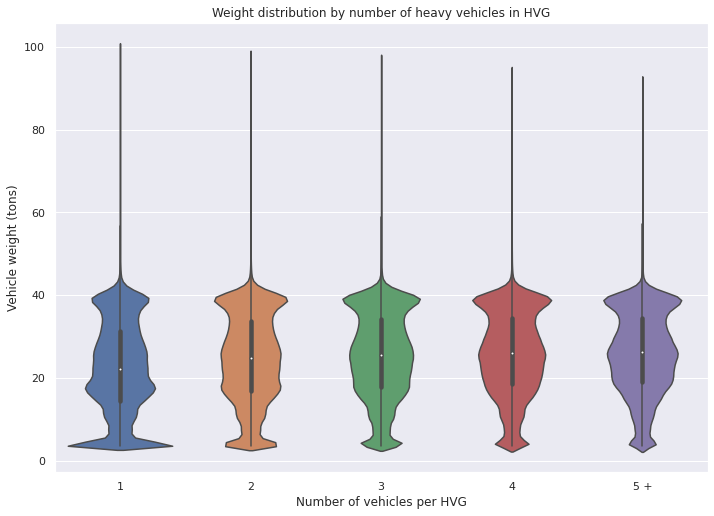

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


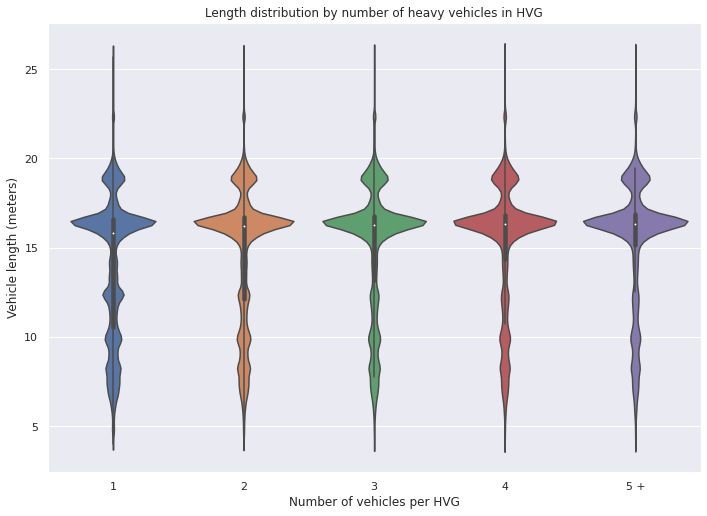

In [28]:
violin_weight_length()

In [ ]:
stations = ['Ceneri', 'Denges', 'Gotthard']

In [ ]:
for station in stations:
    violin_weight_length(station)

## Platoon Finding in Circulation data

The purpose of this section is to investigate the typical headway distances using the 2017 circulation data from the 137 station, near the Ceneri WIM station. The classification of the circulation data is limited to the SWISS10 classification. In this classification there are only 6 different classifications 3 for light vehicles (< 3.5 tons) (2, 3, 4) and 3 for heavy vechicles (> 3.5 tons) (1, 5, 6).

To do this, the time difference between the heavy vehicles will be noted, with no intermediate smaller vehicles

In [2]:
station = 137
year = 2017

In [3]:
heavy = [1, 8, 9, 10]
light = range(2, 8)

In [4]:
df = pd.read_pickle('{}/{}_circ.pkl'.format(station, year))

In [5]:
df.head(-5)

,z,Lane,Dir,Headway,IVT,Speed,Length,SwissT,Time,Date,index
0,0.0,5,1,99.9,99.9,109.0,384.0,3,0.020564,2017-01-01 00:01:14.003,0
1,0.0,2,1,99.9,99.9,110.0,518.0,3,0.023911,2017-01-01 00:01:26.008,1
2,0.0,5,1,13.9,13.8,112.0,379.0,3,0.024450,2017-01-01 00:01:28.002,2
3,0.0,5,1,0.6,0.5,115.0,448.0,3,0.024636,2017-01-01 00:01:28.069,3
4,0.0,5,1,7.5,7.4,116.0,426.0,3,0.026739,2017-01-01 00:01:36.026,4
...,...,...,...,...,...,...,...,...,...,...,...
19019820,0.0,1,1,99.9,99.9,72.0,400.0,3,23.966433,2017-12-31 23:57:59.016,19019820
19019821,0.0,5,1,25.0,24.8,107.0,431.0,3,23.967814,2017-12-31 23:58:04.013,19019821
19019822,0.0,5,1,6.9,6.8,122.0,382.0,3,23.969744,2017-12-31 23:58:11.008,19019822
19019823,0.0,5,1,7.5,7.4,116.0,358.0,3,23.971831,2017-12-31 23:58:18.059,19019823


In [6]:
df.SwissT.unique()

array([ 3,  4,  5,  2,  6, 10,  1,  8,  9,  7,  0, 17, 35, 16],
      dtype=int32)

In [7]:
df.groupby('SwissT').agg({'Date': 'count'})

,Date
SwissT,
0,21
1,116872
2,544649
3,14347974
4,97786
5,2481441
6,81533
7,45669
8,410383


In [8]:
#Only having the vehicles categorized in the SWISS10 will be allowed
all_vehicles = np.concatenate((heavy, light))
df = df[df.SwissT.isin(all_vehicles)]

In [9]:
df.groupby('SwissT').agg({'Date': 'count'})

,Date
SwissT,
1,116872
2,544649
3,14347974
4,97786
5,2481441
6,81533
7,45669
8,410383
9,204580


In [10]:
df['Heavy_veh'] = df.SwissT.isin(heavy)

In [11]:
df.groupby('Heavy_veh').agg({'Date': 'count'})

,Date
Heavy_veh,
False,17599052
True,1404126


In [12]:
df = df[df.Lane == 5] #Keeping only lane 5

In [13]:
df['Adjusted_Headway'] = df['Headway'] - ((df['Length']*36)/(df['Speed']*1000))

In [14]:
df[df['IVT'] < 1].IVT.value_counts()

0.9    127349
0.8    121176
0.7    110265
0.6     95758
0.5     75005
0.4     50196
0.3     26171
0.2      8895
0.1      1460
0.0        63
Name: IVT, dtype: int64

In [15]:
df['Prev_Headway'] = df['IVT'] + df['Headway'].shift(-1)

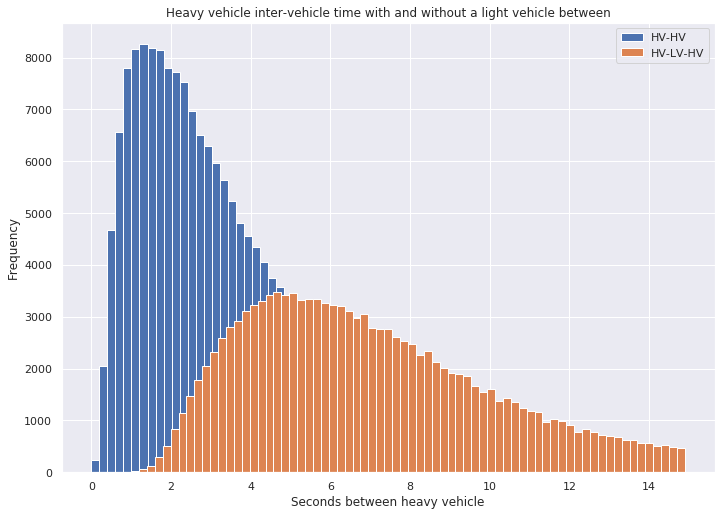

In [23]:
fig, ax = plt.subplots()

h1 = df[(df['IVT'] < 15) & df['Heavy_veh'].shift(-1) & df['Heavy_veh']].IVT.plot.hist(bins=74,title= "{} Natural Truck-Truck Headways, {}".format('137', 2017), ax=ax, label='HV-HV')
h2 = df[(df['Prev_Headway'] < 15) & (~df['Heavy_veh'].shift(-1).fillna(99)) & df['Heavy_veh'] & df['Heavy_veh'].shift(-2)].Prev_Headway.plot.hist(bins=73,title= "Heavy vehicle inter-vehicle time with and without a light vehicle between", ax=ax, label='HV-LV-HV')
#ax.legend((h1, h2), ('Truck-Truck', 'Truck-Car-Truck'), loc='upper right', shadow=True)
ax.legend()
ax.set_xlabel('Seconds between heavy vehicle')
ax.set_ylabel('Frequency')
plt.show()

In [22]:
df[(df['Prev_Headway'] < 15) & (~df['Heavy_veh'].shift(-1).fillna(99)) & df['Heavy_veh'] & df['Heavy_veh'].shift(-2)].Prev_Headway.quantile(0.025)

2.4

The above is the IVT time between trucks that captures Truck-Truck events with only an incidence of capturing 2.5% of the Truck-Car-Truck events

## Making Platoons with all data

Initially upon the platoon creation there was the total weight, classes and length of the vehicles in each platoon but lacked the axle weights, axle distances and headways between each vehicle.

In [7]:
#First read in all historic WIM data
station = 'Ceneri'
df = pd.read_pickle('{}Data/{}_{}_datetime_all.pkl'.format(station, 2003, 2019))

In [ ]:
df = df.set_index('Date')
df = df.sort_index()

In [ ]:
#First, look at constructing IVT (Inter-vehicle time)
df['HEAD_T'] = (df.index.to_series().shift(-1) - df.index.to_series()).dt.total_seconds() #Truck headway

In [ ]:
df.columns

In [ ]:
df['IVT'] = df['HEAD_T'] - (df['LENTH']*3.6)/df['SPEED']

In [ ]:
df['IVT'] = df.IVT.fillna(99) 

In [ ]:
df.IVT.isna().sum()

In [ ]:
df = df[df.SPEED != 0]

In [ ]:
df = df[df.IVT > 0] # Remove any IVT calculated to be less than 0

In [ ]:
df.shape

In [ ]:
df

In [ ]:
df[df.IVT < 10].IVT.hist(bins=100)

In [9]:
#Takes in the station and the number of the inner lanes in both directions for the period of 2014-2016
def one_lane_platoon_all(df):    
    
    mode = False 
    ivt_seconds = 2.4 #2,4 when looking at the 97.5 percentile from only lane 5, corresponding lane to lane 
    lane = 4 
    
    df_lane = df.loc[df['FS'] == lane]

    df_lane = df_lane.set_index('Date')
    df_lane = df_lane.sort_index()
    df_lane['HEAD_T'] =(df_lane.index.to_series().shift(-1) - df_lane.index.to_series()).dt.total_seconds() #Truck headway

    df_lane['IVT'] = df_lane['HEAD_T'] - (df_lane['LENTH']*3.6)/df_lane['SPEED']
    df_lane['IVT'] = df_lane.IVT.fillna(99) 
    df_lane = df_lane[df_lane.IVT > 0] # Remove any IVT calculated to be less than 0 (around 3%)
    
    threshold_selector = df_lane.IVT > ivt_seconds #defines a IVT of threshold
    groups = threshold_selector.cumsum()
    df_lane['Start']  = df_lane.index.to_series()
    df_lane['End'] = df_lane.index.to_series()
    df_lane_platoon = df_lane.groupby(groups).agg({'Start':min, 'End':max, 'CLASS': lambda x: x.tolist(), 'GW_TOT': lambda x: x.tolist(), 'LENTH': lambda x: x.tolist(),
                                                  'AX': lambda x: x.tolist(), 'AX_W': lambda x: x.tolist(), 'AX_DIST': lambda x: x.tolist(), 'IVT': lambda x: x.tolist(), 
                                                  'SPEED': lambda x: x.tolist()})
    df_lane_platoon['Platoon'] = (df_lane_platoon.CLASS.str.len() > 1)
    df_lane_platoon['Length'] = df_lane_platoon.CLASS.str.len()
    #df_plot = df_lane_platoon[df_lane_platoon.Length > 1]
    #ax = df_plot['Length'].plot.hist(bins=10, title= "{} Lane Platoon Frequencies Greater than 1".format(lane)) 
    #ax.set_xlabel('Number of Vehicles in Platoon')
    #plt.show()
    if mode:
        #Display the combinations of platoons that are the most common for 2, 3 and 4 length
        print(df_lane_platoon[df_lane_platoon.Length == 2].CLASS.apply(tuple).value_counts().head().to_string())
        print(df_lane_platoon[df_lane_platoon.Length == 3].CLASS.apply(tuple).value_counts().head().to_string())
        print(df_lane_platoon[df_lane_platoon.Length == 4].CLASS.apply(tuple).value_counts().head().to_string())
    df_lane_platoon['Lane'] = int(lane)
    
    return df_lane_platoon

In [ ]:
station = 'Ceneri'
df = pd.read_pickle('{}Data/{}_{}_datetime_all.pkl'.format(station, 2003, 2019))


In [8]:
def parallelize_dataframe(df, func, n_cores=10):
    df_split = np.array_split(df, n_cores)
    ctx = mp.get_context('spawn')
    pool = ctx.Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
df.columns

In [10]:
platoon_df = parallelize_dataframe(df, one_lane_platoon_all, (mp.cpu_count() - 10))

In [11]:
platoon_df.to_pickle('{}Data/{}_{}_platoon_h{}_lane{}.pkl'.format(station, 2003, 2019,2.4, 4))